<a href="https://colab.research.google.com/gist/AtaberkOcak/ef3550fba587c0b8ea5cccd6cd7b5335/building-regression-tree-on-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Regression Tree on Python**
***Ataberk Ocak***


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Hitters.csv")
trainData=df.sample(frac=0.8,random_state=42)
testData=df.drop(trainData.index).dropna(subset=['Salary'])

In this part, we import the pandas library and our data set. We also divide the data into "train" and "test". We will train our tree with "train data". Then we will calculate the accuracy using "test data".
Usually the data is split into %80/%20. %80 is "train data" and the remaining %20 is "test data".

In [ ]:
def calcRSS(column,t,target,df):  
    trueList=df.dropna(subset=[target]).loc[df[column]<t]
    falseList=df.dropna(subset=[target]).loc[df[column]>=t]
  
    trueListMean=trueList[target].mean()
    falseListMean=falseList[target].mean()
  
    rss=0
    rss+=((trueList[target]-trueListMean)**2).sum()
    rss+=((falseList[target]-falseListMean)**2).sum()
  
    return rss

The residual sum of squares (RSS) measures the level of variance in the error term, or residuals, of a regression model.
The smaller the residual sum of squares, the better your model fits your data; the greater the residual sum of squares, the poorer your model fits your data. If we denote threshold with 't', then 't' starts by taking the value of the lowest element in the data set and then taking the values of the other elements in the data set. We split the data set into "true list" and "false list" according to threshold, then calculate the RSS.

In [ ]:
def columnPicker(df):
    target='Salary'
    best_t=0
    bestColumn=''
    minRSS=0
    columns = df.select_dtypes(include=['integer']).columns

    for column in columns:

        for t in set(df[column]):

            rss = calcRSS(column,t,target,df)
      
            if minRSS==0:
                minRSS=rss

            if rss<=minRSS:
                minRSS=rss
                best_t=t
                bestColumn=column
  
    return bestColumn,best_t,minRSS


In this function, we calculate RSS for all parameters and split the data from the parameter whose RSS is the lowest.

In [ ]:
def prediction(testdata, rules, maxDepth):
  
    if testdata[rules['root'][0]] < rules['root'][1]:
        index = 'L'

        while len(index) < maxDepth :
            
            if len(rules[index]) == 3:
                return rules[index][2]
            
            if testdata[rules[index][0]] < rules[index][1]:
                index += 'L'
            else:
                index += 'R'
        return rules[index][2]

    else:
        index = 'R'

        while len(index) < maxDepth:
            
            if len(rules[index]) == 3:
                return rules[index][2]
      
            if testdata[rules[index][0]] < rules[index][1]:
                index += 'L'
            else:
                index += 'R'
        return rules[index][2]
    return rules[index][2]

By using "prediction" function, after we create our dictionary, we can make predictions for any new data.

In [ ]:
def getSplit(newdf,bestColumn,best_t):
    dfTrue = newdf.loc[newdf[bestColumn]<best_t]
    dfFalse = newdf.loc[newdf[bestColumn]>=best_t]
    
    return dfTrue, dfFalse

It divides the dataset into two different dataframes as (selected column < threshold) and (selected column >= threshold) according to threshold and the column we choose.

In [ ]:
def findAvgSalary(df):
    avg=df['Salary'].mean()
    return avg

Function where we find the average salary.

In [ ]:
def fixIndex(index,depth):
    return index[:depth]

A function to edit the string we use once in the 'treeBuilder' function.

In [ ]:
def treeBuilder(newdf,bestColumn,best_t,minRSS,maxDepth,minSize,depth,rules,index=""):
    dfTrue, dfFalse = getSplit(newdf, bestColumn, best_t)
    
    controller=False
    
    if depth > maxDepth:
        return
    else:
        if len(dfFalse)<=minSize or len(dfTrue)<=minSize:
            controllerColumn=bestColumn
            controllerThreshold=best_t
            controller=True           
            
        if len(dfTrue) <= minSize:
            avg = findAvgSalary(dfTrue)
            rules[index+"L"]=bestColumn,best_t,avg
        else:
            index+="L"
            bestColumn,best_t,minRSS=columnPicker(dfTrue)
            
            if len(index) == maxDepth:
                rules[index] = bestColumn, best_t, findAvgSalary(dfTrue)
            else:
                rules[index] = bestColumn, best_t
                
            
            
            treeBuilder(dfTrue ,bestColumn,best_t, minRSS,maxDepth,minSize, depth+1,rules,index)
        
        if len(index) >= depth:
            index=fixIndex(index,depth-1)
        
        if len(dfFalse) <= minSize:
            avg = findAvgSalary(dfFalse)
                  
            
            if controller==True:
                rules[index+"R"]=controllerColumn,controllerThreshold,avg
                controller==False
            else:
                rules[index+"R"]=bestColumn,best_t,avg
        else:
            index+="R"
            bestColumn,best_t,minRSS = columnPicker(dfFalse)
            
            if len(index) == maxDepth:
                rules[index] = bestColumn, best_t, findAvgSalary(dfTrue)
            else:
                rules[index] = bestColumn, best_t
                
            treeBuilder(dfFalse ,bestColumn,best_t, minRSS, maxDepth, minSize, depth+1,rules,index)
    
    
        
    return rules

If the condition of any feature is met (i.e. "True"), that feature will be registered as "L" in the dictionary. If not provided (i.e. "False"), this time it will be saved as "R" in the dictionary. After each separation, it will take an L or R in addition to its previous name in the dictionary, depending on whether it is True or False.

In [ ]:
def buildTree(trainData, maxDepth):
    rules={}
    bestColumn,best_t,minRSS = columnPicker(trainData)
    rules['root']=bestColumn,best_t
    rules = treeBuilder(trainData ,bestColumn,best_t, minRSS, maxDepth, 7, 1, rules)
    
    return rules

Here we define a dictionary called "rules". We will save the tree we have built in this dictionary.

In [ ]:
def accuracy(trainData, testData, target, rules, maxDepth):

        predictionValues=[]
        rss=0

        for i in testData.index:

            predictionValues.append((prediction(testData.loc[i], rules, maxDepth), testData.loc[i][target]))

        for i in predictionValues:

            rss += ((i[0] - i[1])**2)/len(testData) 

        return rss

In this function, we test the tree which we trained with Train data. But while testing, we using the test data. Then we find the accuracy according to the test data. To make this calculation we use Residual Sum of Squares.

In [ ]:
def findMaxDepth(depth):
    testRssList=[]
    trainRssList=[]
    depthList=[]
    
    while depth<15:
        rules = buildTree(trainData, depth)
        rssTest = accuracy(trainData, testData, 'Salary', rules, depth)
        rssTrain = accuracy(trainData.dropna(), trainData.dropna(), 'Salary', rules, depth)
        testRssList.append(rssTest)
        trainRssList.append(rssTrain)
        depthList.append(depth)
        depth += 1
        
        
        
      
    return testRssList, trainRssList, depthList

In this function, we finding the ideal depth according to accuracy of test data.

In [ ]:
testRssList, trainRssList, depthList = findMaxDepth(1)
minValue = min(testRssList)
maxDepth = testRssList.index(minValue)+1

The function where we find the max depth.

In [ ]:
print("Maximum Depth:", maxDepth)
testRssList

Maximum Depth: 9


[269083.0540821699,
 137061.2767400764,
 397504.4409957976,
 461832.4747858988,
 172175.65521225403,
 144828.0127307206,
 154185.9714849969,
 136357.00371440983,
 135523.8982158761,
 138496.1563264122,
 146511.8547277303,
 136225.53413979738,
 136612.40520897976,
 136612.40520897976]

As can be seen, the lowest RSS was reached at 9 depth.




Text(0, 0.5, 'RSS')

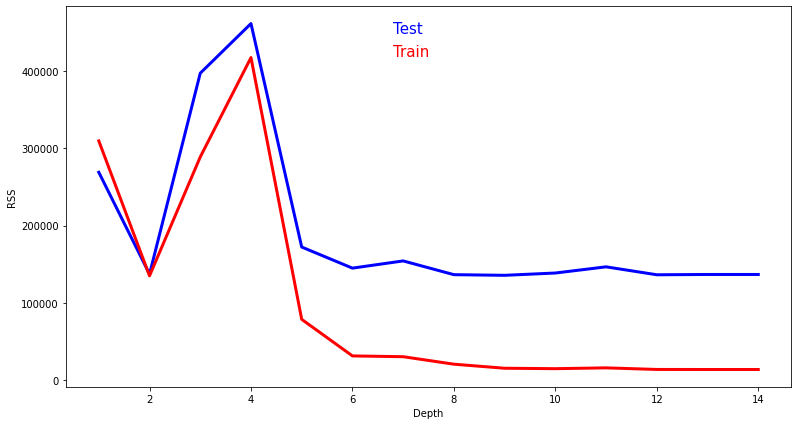

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.plot(depthList,testRssList,color="b",linewidth=3)
plt.plot(depthList, trainRssList, color="r",linewidth=3)
plt.text(6.8, 450000,"Test",color='b',fontsize=15)
plt.text(6.8, 420000,"Train",color='r',fontsize=15)

plt.xlabel("Depth",fontsize=10)
plt.ylabel("RSS",fontsize=10)

As we can see in the chart, the ideal depth is 9. After depth 9 the graph increases and stops changing as it satisfies the minimum size requirement.

In [ ]:
def bagging(trainData, lastDepth):
  rssList = []
  
  for depth in range(1,lastDepth+1):
    
    rss = 0
    baggingPredictionList = []
    
    for i in range(10):
      pruningData = trainData.sample(frac=0.3).dropna(subset=['Salary'])
      rules = buildTree(pruningData, depth)
      baggingPredictionList = baggingListCreater(testData, rules, depth, i, baggingPredictionList)
    
    result = [element/10 for element in baggingPredictionList]
    predictionValues = []
    k=0
    
    for j in testData.index:

      predictionValues.append((result[k],testData.loc[j]['Salary']))
      k+=1
    
    for i in predictionValues:

      rss += ((i[0] - i[1])**2)/len(testData.dropna(subset=['Salary'])) 
    
    rssList.append(rss)
    
  return predictionValues, rssList

Function that implements the 'Bagging' method, which is a pruning method. Using 30% of the train data, 10 different trees are created with random data each time. Then the test data is passed through these trees and the results are obtained. The obtained results are averaged and the RSS values of the trees we create between 1 and 14 depths are calculated.

In [ ]:
def baggingListCreater(testData, rules, maxDepth, k, baggingPredictionList, t=0):
  
  if k == 0:

    for i in testData.index:
      baggingPredictionList.append(prediction(testData.loc[i], rules, maxDepth))
  
  else:
    
    for j in testData.index:

      
      baggingPredictionList[t] = baggingPredictionList[t] + prediction(testData.loc[j], rules, maxDepth)
      t+=1
  return baggingPredictionList

Function to sum and save the results we found while doing the bagging process.

In [ ]:
lastDepth = 14
predictionValues, rssList = bagging(trainData, lastDepth)

Text(0, 0.5, 'RSS')

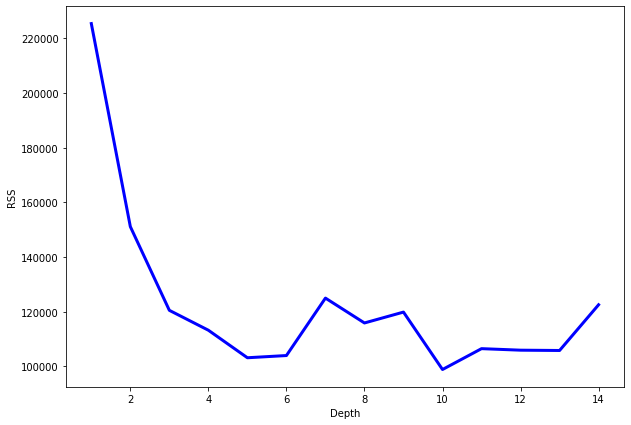

In [ ]:
depthList = [i for i in range(1,lastDepth+1)]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(depthList,rssList,color="b",linewidth=3)
plt.xlabel("Depth",fontsize=10)
plt.ylabel("RSS",fontsize=10)

The RSS data of the model we are used bagging on. According to the result given in the test data, the most suitable model is reached at 10 depths. It is seen that the RSS increases continuously after the depth of 10. 

In [ ]:
rssList

[225437.05370028608,
 151104.3794075274,
 120463.89764484168,
 113182.35121408133,
 103107.59407703202,
 103916.07961844621,
 124944.42955708136,
 115841.96319906531,
 119821.66807909461,
 98805.18387360749,
 106437.95318298475,
 105879.37181170304,
 105765.6359971428,
 122504.28403948084]

Here we can see the RSS values. Let's compare the lowest RSS of our model before bagging with the lowest RSS of our model with bagging. While the RSS of our first model is 135523, the RSS of the model we used pruning on is 98805. As can be seen, the variance of the pruning model has decreased. In this way, it has become a model that makes more accurate predictions. 